In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score
from data_processing import (
    getDatasets,
    create_statistical_features,
    perform_kmeans_clustering
)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import joblib
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load datasets
datasets = getDatasets()

# Road surface columns
surface_cols = ['dirt_road', 'cobblestone_road', 'asphalt_road']

# Combine left, right data and labels for each PVS
combined_datasets = pd.DataFrame({
    'pvs': list(datasets.keys()),
    'dataframe': [
        pd.concat([
            datasets[pvs_key]['data_left'].add_suffix('_left'),
            datasets[pvs_key]['data_right'].add_suffix('_right'),
            datasets[pvs_key]['data_labels'][surface_cols].idxmax(axis=1).rename('road_surface')
        ], axis=1)
        for pvs_key in datasets.keys()
    ]
})


In [3]:
# Encode road_surface labels for all PVS dataframes
surface_mapping = {
    'asphalt_road': 0,
    'cobblestone_road': 1,
    'dirt_road': 2
}

for df in combined_datasets['dataframe']:
    df['road_surface'] = df['road_surface'].map(surface_mapping).astype('int8')

In [4]:
# Normalize sensor data and create statistical features over a rolling window
for i, row in combined_datasets.iterrows(): # iterate over each PVS dataframe, i = index, row = Series
    df = row['dataframe']
    
    # Normalize sensor data
    sensor_cols = df.columns.difference(['road_surface'])
    scaler = StandardScaler()

    # Keep only acc, gyro, mag, and speed sensor columns (plus label)
    allowed_keywords = ('acc', 'gyro', 'mag', 'speed')
    sensor_cols = [col for col in df.columns if col != 'road_surface' and any(k in col for k in allowed_keywords)]
    road_surface = df['road_surface']
    df = df[sensor_cols]
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    
    # Create statistical features
    df = create_statistical_features(df, sensor_cols, window_size=300)
    df['road_surface'] = road_surface # add back the labels

    if df.isnull().values.any():
        df = df.fillna(0)
    
    # Update the dataframe in the combined_datasets
    combined_datasets.at[i, 'dataframe'] = df # the .at accessor is used for fast scalar access

combined_datasets.dataframe[0].head()

/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_19851/31640324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
/Users/nicks/Library/CloudStorage/OneDrive-Personal/Documents/Python/M25_Capstone/Imperial-College-Capstone/notebooks/../src/data_processing.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_std'] = data[col].rolling(window=window_size, min_periods=1).std()
/Users/nicks/Library/CloudStorage/OneDrive-Personal/Documents

,acc_x_dashboard_left_mean,acc_x_dashboard_left_std,acc_x_dashboard_left_var,acc_y_dashboard_left_mean,acc_y_dashboard_left_std,acc_y_dashboard_left_var,acc_z_dashboard_left_mean,acc_z_dashboard_left_std,acc_z_dashboard_left_var,acc_x_above_suspension_left_mean,...,mag_y_above_suspension_right_mean,mag_y_above_suspension_right_std,mag_y_above_suspension_right_var,mag_z_above_suspension_right_mean,mag_z_above_suspension_right_std,mag_z_above_suspension_right_var,speed_right_mean,speed_right_std,speed_right_var,road_surface
0,0.383223,0.000000,0.000000,0.078733,0.000000,0.000000,0.040739,0.000000,0.000000,0.332384,...,2.010413,0.000000,0.000000,2.157061,0.000000,0.000000,-1.232546,0.0,0.0,0
1,0.393058,0.013909,0.000193,0.080892,0.003053,0.000009,0.034531,0.008779,0.000077,0.353259,...,1.934513,0.107339,0.011522,2.171429,0.020319,0.000413,-1.232546,0.0,0.0,0
2,0.400327,0.015977,0.000255,0.082434,0.003435,0.000012,0.025491,0.016843,0.000284,0.334858,...,1.906402,0.090175,0.008132,2.181007,0.021947,0.000482,-1.232546,0.0,0.0,0
3,0.397120,0.014537,0.000211,0.081046,0.003946,0.000016,0.023258,0.014459,0.000209,0.331688,...,1.892346,0.078812,0.006211,2.185797,0.020319,0.000413,-1.232546,0.0,0.0,0
4,0.397932,0.012719,0.000162,0.079720,0.004525,0.000020,0.034988,0.029065,0.000845,0.334425,...,1.910899,0.079872,0.006380,2.177176,0.026101,0.000681,-1.232546,0.0,0.0,0


In [5]:
# Split data into training and testing sets - use specific PVS for training
selected_dfs_train = [combined_datasets['dataframe'][i] for i in [0, 1, 2, 6, 7, 8]]
# selected_dfs_train = [combined_datasets['dataframe'][i] for i in [0, 1, 2, 3, 4, 5]]
X_train = pd.concat(selected_dfs_train, ignore_index=True).drop(columns=['road_surface'])
y_train = pd.concat([df['road_surface'] for df in selected_dfs_train], ignore_index=True)

selected_dfs_test = [combined_datasets['dataframe'][i] for i in [3, 4, 5]]
# selected_dfs_test = [combined_datasets['dataframe'][i] for i in [6, 7, 8]]
X_test = pd.concat(selected_dfs_test, ignore_index=True).drop(columns=['road_surface'])
y_test = pd.concat([df['road_surface'] for df in selected_dfs_test], ignore_index=True)

print(f"train test split % : {len(X_train)/(len(X_train)+len(X_test))*100:.2f}% train, {len(X_test)/(len(X_train)+len(X_test))*100:.2f}% test")

train test split % : 66.45% train, 33.55% test


### Create Convolutional Neural Network

In [6]:
# 1. Convert to tensors - required for PyTorch
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

In [7]:
# Original shape: (num_samples, 150)
# Target shape: (num_samples, 150, 1) - 150 channels, sequence length of 1 (for kernel size 1)

X_train_reshaped = X_train_tensor.unsqueeze(2)  #unsqueeze(2) adds a dimension at the end, (N, 150, 1)
X_test_reshaped = X_test_tensor.unsqueeze(2)

print(f"Original X_train shape: {X_train_tensor.shape}")
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")

# Adding the third dimension (only 1 time step) allows the Conv1D layer to process the features as separate channels

# 2. Create DataLoaders - enable batch processing and shuffling
batch_size = 256
train_dataset = TensorDataset(X_train_reshaped, y_train_tensor)
test_dataset = TensorDataset(X_test_reshaped, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Original X_train shape: torch.Size([718257, 150])
Reshaped X_train shape: torch.Size([718257, 150, 1])


- 150 channels: 150 pre-computed statistical features
- 1 timestep: Each sample is a single aggregated summary
- No temporal sequence: Each row is independent

What kernel_size=1 does:

- Looks at 1 timestep (which is all you have)
- Processes all 150 features simultaneously
- Acts like a fully connected layer across features
- No temporal patterns can be learned (sequence length = 1)

In [8]:
# 3. Define CNN architecture
class RoadSurfaceNN(nn.Module):
    def __init__(self, input_channels=150, num_classes=3):
        super(RoadSurfaceNN, self).__init__()
        
        # 1D Convolutions across features
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.15)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        self.relu2 = nn.ReLU()  
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.15)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)

        # Global Average Pooling to reduce feature maps to fixed size
        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        
        # Fully connected layers
        self.fc1 = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)
        
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Total trainable parameters: {total_params:,}')
    
    def forward(self, x):
        # x shape: (batch, 150, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout3(x)

        # Global pooling
        x = self.gap(x)  # (batch, 32, 1)
        x = x.squeeze(2)  # (batch, 32)

        # Fully connected
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        
        return x

# Create model
cnn_model = RoadSurfaceNN(input_channels=150, num_classes=3)
print(cnn_model)

# Input 1x150x1 - (150 features, 1 time step)
# Conv1d: applies convolution over the feature dimension
# Here, kernel_size=1 means the convolution looks at each feature independently (no temporal context)
# This is suitable since each row is already a summary of 3 seconds of data

# Output_size = floor((input_size - kernel_size) / stride) + 1
# Conv1: 150 channels with 64 filters, each filters can specially learn patterns across the 150 features. No weights = channels*filters*kernel_size = 150*64*1 + 64 (bias) = 9664
# BtchNrm1: (batch, 64, 1) normalise outputs from Conv1 layer - subtract mean, divide by stddev. Gamma + Beta = 64 + 64 = 128
# ReLU: (batch, 64, 1) introduce non-linearity
# Dropout: (batch, 64, 1) randomly zero out 30% of activations to prevent overfitting
# Conv2: 64 channels with 32 filters, each learning patterns from the 64 features. No weights = channels*filters*kernel_size = 64*32*1 + 32 (bias) = 2080
# BtchNrm2: (batch, 32, 1) normalise outputs from Conv2 layer - subtract mean, divide by stddev. Gamma + Beta = 32 + 32 = 64
# Conv3: 32 channels with 32 filters, each learning patterns from the 32 features. No weights = channels*filters*kernel_size = 32*32*1 + 32 (bias) = 1056
# BtchNrm3: (batch, 32, 1) normalise outputs from Conv3 layer - subtract mean, divide by stddev. Gamma + Beta = 32 + 32 = 64
# Fully Connected Layer Input: 32x32 = 1024 weights + 32 bias = 1056
# Fully Connected Layer Output: 32x3 = 96 weights + 3 bias = 99
# Total weights = 9664 + 128 + 2080 + 64 + 1056 + 64 + 1056 + 99 = 14,211

Total trainable parameters: 14,211
RoadSurfaceNN(
  (conv1): Conv1d(150, 64, kernel_size=(1,), stride=(1,))
  (relu1): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.15, inplace=False)
  (conv2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.15, inplace=False)
  (conv3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  (relu3): ReLU()
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (gap): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)


In [9]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader): # Loop over each batch in the DataLoader
        inputs, labels = inputs.to(device), labels.to(device) # Move data to device

        optimizer.zero_grad()
        outputs = model(inputs) # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels) # Compute the loss between predicted outputs and true labels
        loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters based on computed gradients
        
        running_loss += loss.item() # loss.item() gets the scalar value of the loss tensor which is accumulated to running_loss for all batches in the epoch
        _, predicted = outputs.max(1) # Get the index of the max log-probability (predicted class)
        total += labels.size(0) # Update total number of samples
        correct += predicted.eq(labels).sum().item() # Update number of correct predictions
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    print(f'Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    """Test the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader) # Average loss over all batches
    test_acc = 100. * correct / total # Accuracy percentage
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    return test_loss, test_acc

def main(model, epochs=10):
    """Simplified main function - uses global variables for data loaders etc."""
    device = torch.device('mps')

    # Move model to device
    model.to(device)

    # Create optimizer and criterion AFTER moving model
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        print('-' * 50)
    
    print('Training completed!')
    return model

# To start training, run:
trained_face_model = main(cnn_model, epochs=10)

Epoch 1: Train Loss: 0.0636, Train Acc: 97.76%
Test Loss: 0.3404, Test Acc: 91.52%
--------------------------------------------------
Epoch 2: Train Loss: 0.0216, Train Acc: 99.25%
Test Loss: 0.4990, Test Acc: 90.29%
--------------------------------------------------
Epoch 3: Train Loss: 0.0159, Train Acc: 99.47%
Test Loss: 0.4784, Test Acc: 90.36%
--------------------------------------------------
Epoch 4: Train Loss: 0.0138, Train Acc: 99.54%
Test Loss: 0.4638, Test Acc: 91.30%
--------------------------------------------------
Epoch 5: Train Loss: 0.0123, Train Acc: 99.59%
Test Loss: 0.5154, Test Acc: 90.26%
--------------------------------------------------
Epoch 6: Train Loss: 0.0109, Train Acc: 99.64%
Test Loss: 0.5493, Test Acc: 89.75%
--------------------------------------------------
Epoch 7: Train Loss: 0.0095, Train Acc: 99.69%
Test Loss: 0.4821, Test Acc: 90.88%
--------------------------------------------------
Epoch 8: Train Loss: 0.0090, Train Acc: 99.71%
Test Loss: 0.57


Confusion Matrix: Road Surface Classification
                |                Predicted                
         Actual |   Asphalt    Cobblestone      Dirt    
------------------------------------------------------------
        Asphalt |    144644        1899         321     
    Cobblestone |     1024        93491        12939    
           Dirt |     188         17879        90263    

Overall Accuracy: 0.9056 (90.56%)
Total Test Samples: 362648
Correct Predictions: 328398

Per-Class Metrics:
------------------------------------------------------------
Class           Precision    Recall       F1-Score    
------------------------------------------------------------
Asphalt         0.992        0.985        0.988       
Cobblestone     0.825        0.870        0.847       
Dirt            0.872        0.833        0.852       


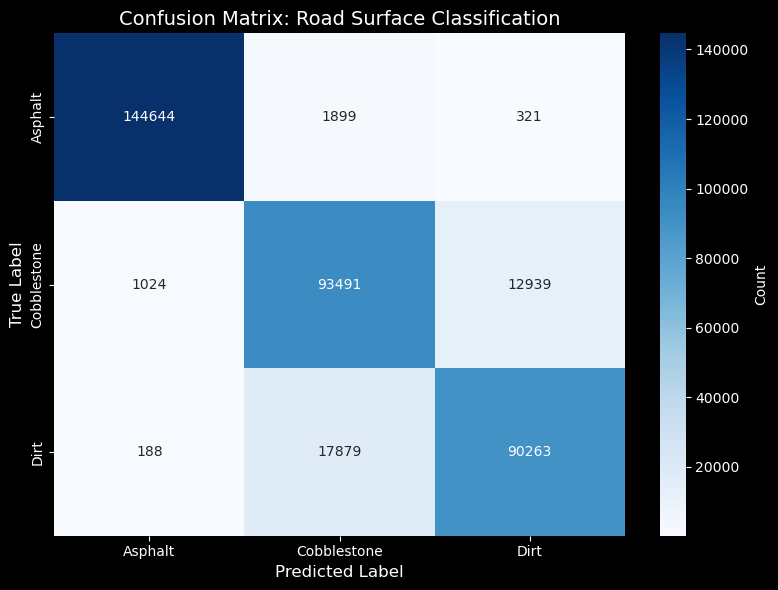


Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Asphalt       0.99      0.98      0.99    146864
 Cobblestone       0.83      0.87      0.85    107454
        Dirt       0.87      0.83      0.85    108330

    accuracy                           0.91    362648
   macro avg       0.90      0.90      0.90    362648
weighted avg       0.91      0.91      0.91    362648



In [10]:
# Generate confusion matrix for road surface classification
device = torch.device('mps')

# Road surface classes
surface_classes = ['Asphalt', 'Cobblestone', 'Dirt']

# Collect all predictions and true labels
all_predictions = []
all_labels = []

cnn_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_model(inputs)
        _, predicted = outputs.max(1)
        
        # Collect predictions and labels (move back to CPU for sklearn)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print confusion matrix
print("\nConfusion Matrix: Road Surface Classification")
print("=" * 60)
print(f"{'':>15} | {'Predicted':^40}")
print(f"{'Actual':>15} | {surface_classes[0]:^12} {surface_classes[1]:^12} {surface_classes[2]:^12}")
print("-" * 60)
for i, true_class in enumerate(surface_classes):
    print(f"{true_class:>15} | {cm[i][0]:^12d} {cm[i][1]:^12d} {cm[i][2]:^12d}")

# Calculate overall metrics
total = cm.sum()
correct = np.trace(cm)  # Sum of diagonal (correct predictions)
accuracy = correct / total

print(f"\n{'='*60}")
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")

# Per-class metrics
print(f"\n{'='*60}")
print("Per-Class Metrics:")
print("-" * 60)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)

for i, class_name in enumerate(surface_classes):
    # Precision: TP / (TP + FP)
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    
    # Recall: TP / (TP + FN)
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    
    # F1-Score: harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name:<15} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=surface_classes, 
            yticklabels=surface_classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Road Surface Classification', fontsize=14)
plt.tight_layout()
plt.show()

# Detailed classification report
print(f"\n{'='*60}")
print("Detailed Classification Report:")
print("-" * 60)
print(classification_report(all_labels, all_predictions, target_names=surface_classes))


In [11]:
#joblib.dump(cnn_model, '../models/CNN_road_classification.pkl')